In [12]:
import pandas as pd
import os
import json
annotations_file= r"C:\Users\emnad\Downloads\updated_merged_json.json"
images_folder = r"C:\Users\emnad\Downloads\extracted"

with open(annotations_file, 'r', encoding='utf-8') as f:
    annotations_list = json.load(f)

annotations = {
    os.path.basename(item['image_path']): item['text']
    for item in annotations_list
}

data = []

for image_file in os.listdir(images_folder):
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(images_folder, image_file)
        label = annotations.get(image_file, None)
        data.append({'image_path': image_path, 'label': label})

df = pd.DataFrame(data)

print(df.head())

                                          image_path        label
0  C:\Users\emnad\Downloads\extracted\01 sep 2023...  01 Sep 2023
1    C:\Users\emnad\Downloads\extracted\02-06-23.png     02/06/23
2  C:\Users\emnad\Downloads\extracted\02-10-2023.png   02/10/2023
3     C:\Users\emnad\Downloads\extracted\02-6-23.png      02/6/23
4  C:\Users\emnad\Downloads\extracted\03-10-2023.png     03/10/23


In [13]:
from datasets import Dataset
from PIL import Image
import pandas as pd

dataset = Dataset.from_pandas(df)
dataset = dataset.rename_columns({"image_path": "image", "label": "text"})

In [14]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from transformers.utils import logging
logging.set_verbosity_error()  # Options: info / warning / error

# Load processor and model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten", use_fast=False)
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id


In [15]:
from PIL import Image
import torch

# Preprocessing function
def preprocess(example):
    try:
        # Skip if text is missing or empty
        if example.get("text") is None or str(example["text"]).strip() == "":
            return None

        # Open and process image
        image = Image.open(example["image"]).convert("RGB")
        pixel_values = processor(images=image, return_tensors="pt").pixel_values[0]

        # Tokenize label
        labels = processor.tokenizer(
            example["text"],
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=128
        ).input_ids[0]

        # Replace pad token with -100
        labels[labels == processor.tokenizer.pad_token_id] = -100

        return {"pixel_values": pixel_values, "labels": labels}

    except Exception as e:
        print(f"Skipping example due to error: {e}")
        return None
# Apply map with remove_columns and filter afterward
processed_dataset = dataset.map(preprocess, remove_columns=dataset.column_names)

# Remove failed examples (None returns)
processed_dataset = processed_dataset.filter(lambda example: example is not None)


Map:   0%|          | 0/627 [00:00<?, ? examples/s]

Filter:   0%|          | 0/624 [00:00<?, ? examples/s]

In [16]:
class OCRDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            'pixel_values': item['pixel_values'],
            'labels': item['labels']
        }


In [17]:
from torch.utils.data import Dataset, DataLoader
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from transformers import AdamW
from PIL import Image
import torch
import cv2
import numpy as np

ImportError: cannot import name 'AdamW' from 'transformers' (C:\Users\emnad\anaconda3\Lib\site-packages\transformers\__init__.py)

In [18]:
from torch.utils.data import Dataset, DataLoader
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from torch.optim import AdamW  # Import AdamW from torch.optim
from PIL import Image
import torch

In [19]:
train_dataloader = torch.utils.data.DataLoader(
    OCRDataset(processed_dataset, processor),
    batch_size=4,
    shuffle=True,
    collate_fn=lambda x: {
        'pixel_values': torch.cat([i['pixel_values'] for i in x], dim=0),
        'labels': torch.cat([i['labels'] for i in x], dim=0)
    }
)

In [26]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer

class CustomTrainer(Seq2SeqTrainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        pixel_values = inputs.get("pixel_values")

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        return (loss, outputs) if return_outputs else loss


training_args = Seq2SeqTrainingArguments(
    output_dir="./trocr-finetuned",
    per_device_train_batch_size=4,
    num_train_epochs=5,
    logging_steps=10,
    save_steps=500,
    evaluation_strategy="no",
    learning_rate=5e-5,
    save_total_limit=2,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset,
)


trainer.train()
model.save_pretrained("./trocr-finetuned")
processor.save_pretrained("./trocr-finetuned")

NameError: name 'TrainingArguments' is not defined

In [3]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor

model = VisionEncoderDecoderModel.from_pretrained("./trocr-finetuned")
processor = TrOCRProcessor.from_pretrained("./trocr-finetuned")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 1024,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.50.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_


image 1/1 C:\Users\emnad\Downloads\datasetsplit1\test\Bulletin_de_soin\430890210_1360124484505691_7576348555829998378_n.png: 640x480 7 manuscrits, 98.3ms
Speed: 7.4ms preprocess, 98.3ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 480)
Résultat sauvegardé sous : detection_result.jpg


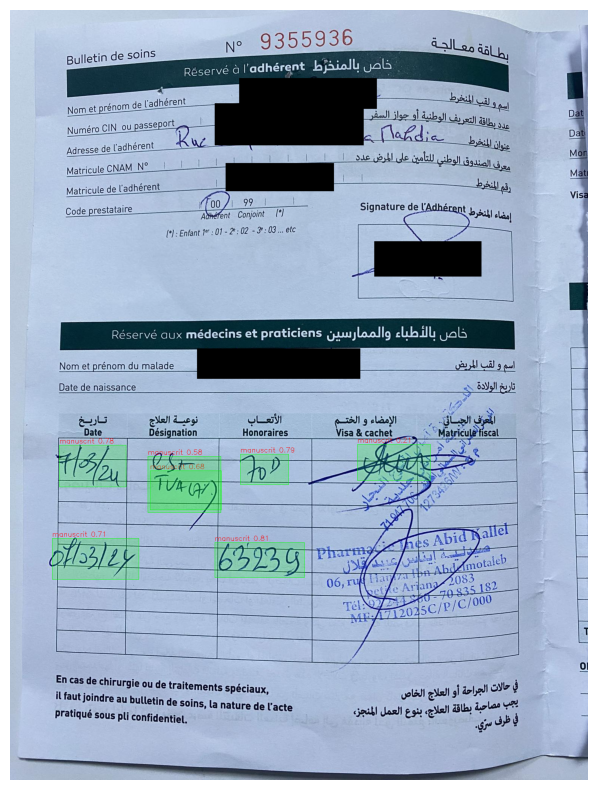

In [1]:
 import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

# Charger le modèle YOLOv8
yolo_model = YOLO("runs/detect/train6/weights/best.pt")

# Charger l'image
image_path =  r"C:\Users\emnad\Downloads\datasetsplit1\test\Bulletin_de_soin\430890210_1360124484505691_7576348555829998378_n.png"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Conversion pour Matplotlib

# Détection avec un seuil de confiance bas
results = yolo_model(image_path, conf=0.05)

# Paramètres personnalisés pour les boîtes
box_alpha = 0.2  # Transparence du remplissage
line_width = 1    # Épaisseur des contours
font_scale = 0.6  # Taille du texte
text_color = (255, 0, 0)  # Couleur du texte (bleu)
box_color = (0, 255, 0)   # Couleur des boîtes (vert)

# Créer une copie pour l'annotation
annotated_image = image.copy()

for result in results:
    for box in result.boxes:
        # Coordonnées de la boîte
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        
        # Dessiner le rectangle avec transparence
        overlay = annotated_image.copy()
        cv2.rectangle(overlay, (x1, y1), (x2, y2), box_color, -1)  # Remplissage
        annotated_image = cv2.addWeighted(overlay, box_alpha, annotated_image, 1 - box_alpha, 0)
        
        # Contour de la boîte
        cv2.rectangle(annotated_image, (x1, y1), (x2, y2), box_color, line_width)
        
        # Texte (classe + confiance)
        label = f"{result.names[int(box.cls)]} {box.conf[0]:.2f}"
        cv2.putText(annotated_image, label, (x1, y1 - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, 1)

# Affichage
plt.figure(figsize=(12, 10))
plt.imshow(annotated_image)
plt.axis("off")

# Enregistrer le résultat si besoin
output_path = "detection_result.jpg"
cv2.imwrite(output_path, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
print(f"Résultat sauvegardé sous : {output_path}")

plt.show()

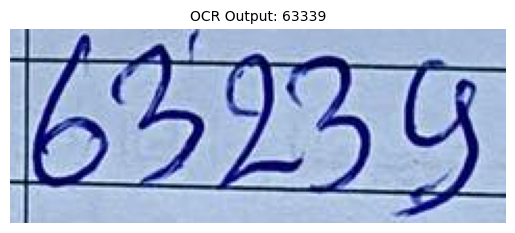

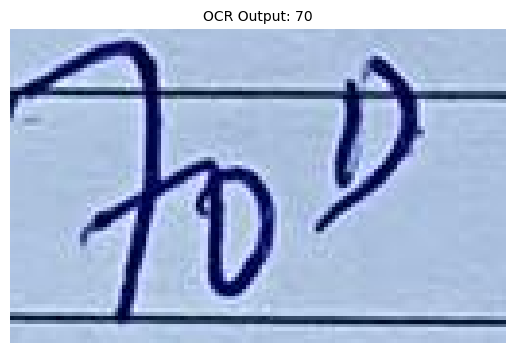

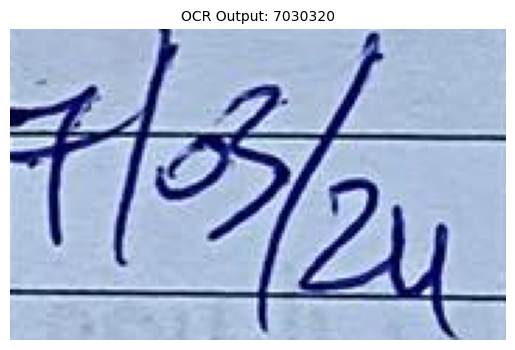

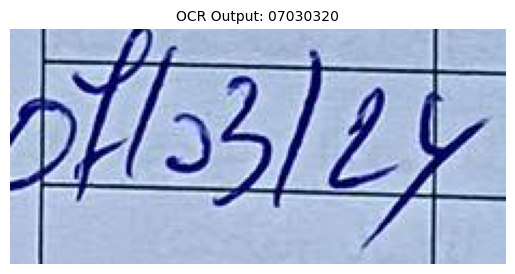

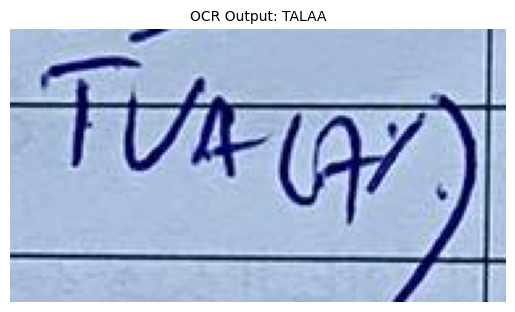

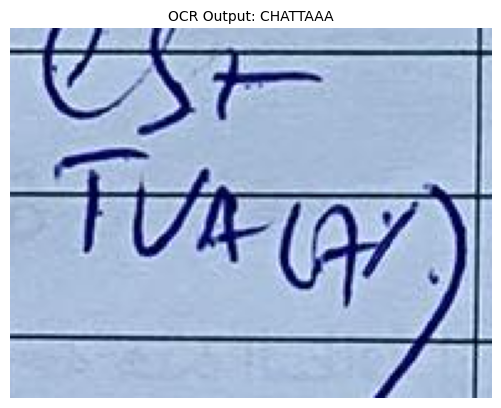

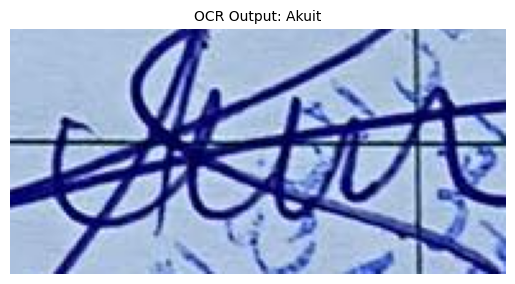

In [4]:
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt

# OCR on YOLO segments using the original image
for result in results:
    for i, box in enumerate(result.boxes):
        # Get the bounding box coordinates (x1, y1, x2, y2)
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())

        # Convert the NumPy image to PIL image for cropping
        image_pil = Image.fromarray(image)

        # Crop the image using PIL's crop method
        cropped = image_pil.crop((x1, y1, x2, y2))

        # Convert the cropped image to NumPy array
        cropped_np = np.array(cropped)

        # Check if the cropped image has valid dimensions
        if cropped_np.size == 0:  # Skip empty crops
            continue

        # Preprocess the cropped image for the OCR model
        inputs = processor(images=cropped, return_tensors="pt").pixel_values
        inputs = inputs.to(model.device)

        # Perform OCR prediction
        with torch.no_grad():
            output = model.generate(inputs)

        # Decode the output to text
        text = processor.batch_decode(output, skip_special_tokens=True)[0]

        # Ensure there is valid text
        if text.strip() == "":
            text = "No text detected"

        # Plot the cropped region with the OCR text
        plt.figure()
        plt.imshow(cropped)
        plt.axis("off")
        plt.title(f"OCR Output: {text}", fontsize=10)  # Display OCR text under the segment
        plt.show()


In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments
from torch.utils.data import Dataset
from PIL import Image
import torch
import json
import os

# Charger le processor et le modèle
model_name = "microsoft/trocr-large-handwritten"
processor = TrOCRProcessor.from_pretrained(model_name)
model = VisionEncoderDecoderModel.from_pretrained(model_name)

# Fixer les tokens nécessaires pour éviter les erreurs
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id or processor.tokenizer.bos_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# Utiliser le GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Charger le fichier JSON
with open("updated_merged_json.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Créer un Dataset personnalisé
class HandwrittenDataset(Dataset):
    def __init__(self, data, processor):
        self.data = data
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(item["image_path"]).convert("RGB")
        text = item["text"]

        # Préparation de l'image et du texte
        pixel_values = self.processor(images=image, return_tensors="pt").pixel_values.squeeze()
        labels = self.processor.tokenizer(text, padding="max_length", max_length=128, truncation=True, return_tensors="pt").input_ids.squeeze()

        labels[labels == processor.tokenizer.pad_token_id] = -100  # Ignore padding dans le loss

        return {"pixel_values": pixel_values, "labels": labels}

# Créer dataset + split
dataset = HandwrittenDataset(data, processor)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, eval_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Arguments d'entraînement
training_args = Seq2SeqTrainingArguments(
    output_dir="./trocr-handwritten-finetuned",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    num_train_epochs=10,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,  # processor remplace tokenizer
)

# Entraînement 🚀
trainer.train()

# Sauvegarde finale
model.save_pretrained("./trocr-handwritten-finetuned")
processor.save_pretrained("./trocr-handwritten-finetuned")


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 1024,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.50.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_

Epoch,Training Loss,Validation Loss
1,3.961700,3.863482
